# Data Loading
Data was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96058, unzipped and stored in the data folder. 
The raw dataset is named "em" and its path can be found in the analysis .env file.

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 


em = pd.read_csv(os.getenv("EM"), index_col=0)

In [25]:
em.shape

(30865, 3409)

Traditionally, gene expression matrix data is in the format that each row is a gene and each column is a sample (because it's the default for most microarray, RNA-seq, and general bioinformatics data formats).  
I am however transposing the dataset, for two reasons:
1. I will be performing machine learning later on, which will require this input format (e.g. scikit-learn).
2. I am more familiar with this format.

In [26]:
em_T = em.T
print(f"Initial shape (samples x genes): {em_T.shape}")

Initial shape (samples x genes): (3409, 30865)


## Loading of CLinical Metadata
I also load this here because I might flag samples later.

In [38]:
clinical_df = pd.read_csv(os.getenv("CLINICAL_LLM"), index_col=0) # CLINICAL_LLM is the one that is not one-hot encoded -> better for analysis 

print(f"Sample metadata shape: {clinical_df.shape}")
print("Sample columns:", clinical_df.columns.tolist())
print(clinical_df.head())


Sample metadata shape: (3409, 16)
Sample columns: ['last_update_date', 'instrument model', 'age at diagnosis', 'tumor size', 'lymph node group', 'lymph node status', 'er status', 'pgr status', 'her2 status', 'ki67 status', 'nhg', 'pam50 subtype', 'overall survival days', 'overall survival event', 'endocrine treated', 'chemo treated']
          last_update_date instrument model  age at diagnosis  tumor size  \
sample_id                                                                   
F1             May 04 2022       HiSeq 2000                43         9.0   
F2             May 04 2022       HiSeq 2000                48        14.0   
F3             May 04 2022       HiSeq 2000                69        27.0   
F4             May 04 2022       HiSeq 2000                39        51.0   
F5             May 04 2022       HiSeq 2000                73        60.0   

          lymph node group  lymph node status  er status  pgr status  \
sample_id                                           

## Initial Overlook
For the very first outlook over the data, a plot to see the distribution of the values

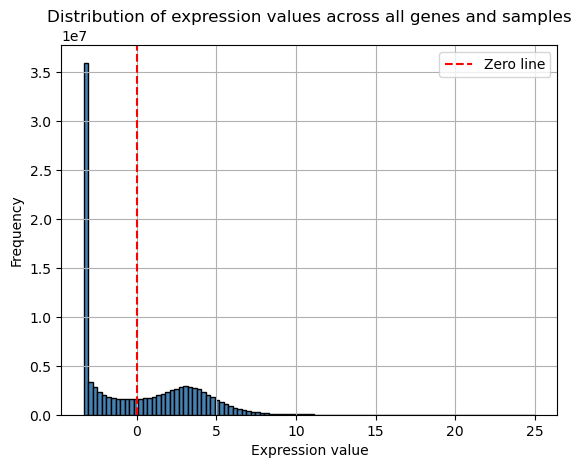

In [34]:
all_values = em.values.flatten()

# Plot a histogram
plt.hist(all_values, bins=100, color='steelblue', edgecolor='black')
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of expression values across all genes and samples")
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--', label='Zero line')
plt.legend()
plt.show()

Interesting:
- we see that there is a spike
- the spike is NOT at zero as we might expect
- there are negative values


Spike around -3: wondering where this value came from, could be a placeholder for no expression.

Edit: 
The paper on the preprocessing of the dataset (https://pubmed.ncbi.nlm.nih.gov/32913985/) mentions:
"Gene expression data were pre-processed by collapsing on 27,979 unique gene symbols (sum of FPKM values of each matching transcript), adding to each gene’s expression measurement 0.1 FPKM, performing a log2 transformation, and centering the gene expression values by subtracting the row-wise (gene) median (calculated across the 49 primary data sets) from the values in each row of data."

-> That would mean all rows with -3.219 have no expression. (because it is log(0+0.1)).

BUT:
- distribution is still right-skewed and not centered at zero -> no median zentering was applied yet?!

## Constant Columns
In the preview, I noticed that there are columns that only contained one unique value in the whole dataset, so I deleted these columns to save computational time and power.

Since it is unlikely that a column is constant for expression other than 0 expression, likely all columns that are constant are columns of gnees that are not being expressed at all, so I identify this.

In [28]:
constant_cols = em_T.columns[em_T.nunique() <= 1]
print(f"Number of constant columns: {len(constant_cols)}")
if len(constant_cols) > 0:
    print("Example constant columns:", constant_cols[:5].tolist())

if len(constant_cols) > 0:
    print("Constant columns and their unique value:")
    for col in constant_cols[:5]:
        unique_val = em_T[col].unique()
        print(f"{col}: {unique_val}")

Number of constant columns: 2236
Example constant columns: ['AB167336', 'AB209638', 'AB240007', 'AB240039', 'AB360851']
Constant columns and their unique value:
AB167336: [-3.32192809]
AB209638: [-3.32192809]
AB240007: [-3.32192809]
AB240039: [-3.32192809]
AB360851: [-3.32192809]


## Low expression Columns
The next step is to analyse whether we have columns that have low expression, they would not add to the value and cost computational time.

Number of low-expression columns: 4715
Example low-expression columns: ['6M1-18', '7M1-2', 'AA06', 'AB052595', 'AB107049']


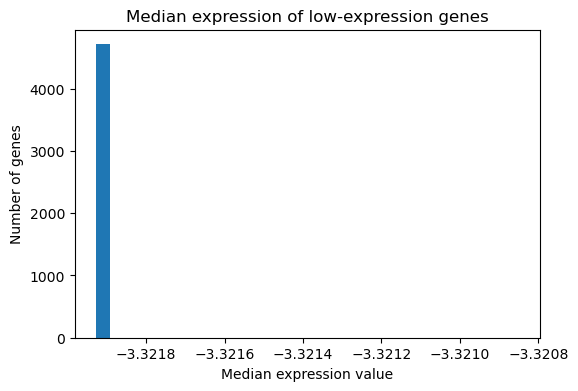

In [29]:
import numpy as np
pseudo_zero = np.log2(0.1)  # This is the value used in the dataset for no expression
tolerance = 1e-2
min_samples = int(0.01 * em_T.shape[0])

# Count how many samples have expression different from pseudo_zero
expressed = (np.abs(em_T - pseudo_zero) > tolerance).sum(axis=0)
low_expression_cols = expressed[expressed < min_samples].index
print(f"Number of low-expression columns: {len(low_expression_cols)}")
if len(low_expression_cols) > 0:
    print("Example low-expression columns:", low_expression_cols[:5].tolist())

medians = em_T[low_expression_cols].median(axis=0)
plt.figure(figsize=(6,4))
plt.hist(medians, bins=30)
plt.xlabel("Median expression value")
plt.ylabel("Number of genes")
plt.title("Median expression of low-expression genes")
plt.show()

In [30]:
n_cols_before = em_T.shape[1]

print(f"Number of columns before dropping constant and low expression columns: {n_cols_before}")

# Drop constant columns
cleaned_em_T = em_T.drop(columns=constant_cols)
print(f"Dropped {len(constant_cols)} constant columns.")


remaining_low_expression_cols = [col for col in low_expression_cols if col in cleaned_em_T.columns]

filtered_em_T = cleaned_em_T.drop(columns=remaining_low_expression_cols)
print(f"Dropped {len(remaining_low_expression_cols)} low-expression columns.")

print(f"Number of columns after dropping constant & low-expression columns: {filtered_em_T.shape[1]}")

Number of columns before dropping constant and low expression columns: 30865
Dropped 2236 constant columns.
Dropped 2479 low-expression columns.
Number of columns after dropping constant & low-expression columns: 26150


## NA-Check

In [31]:
na_cols = filtered_em_T.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


There are no NA values to take care of.

## Exporting the Filtered Dataset
I want to export the current state of the dataset as "filltered", meaning that no other preprocessing besides removal of constant and low-expression columns.

In [32]:
filtered_em_T.to_csv(os.getenv("FILTERED"), float_format='%.20f')
print(f"Filtered dataset saved to {os.getenv('FILTERED')}") 

Filtered dataset saved to /Users/sarah/Code/bioinformatics-tool/backend/data/GSE96058_filtered.csv


# Quality Check

## Distribution of Expression across samples
Trying to see whether there are samples that have constant high expression or low expression. In the next step, I try plot the distribution and identify the highest and lowest 1% of expression.

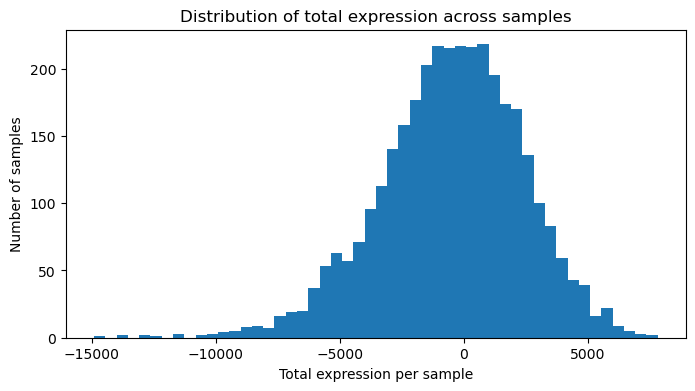

Number of expression sum outlier samples: 70


In [35]:
sample_sums = em_T.sum(axis=1)
plt.figure(figsize=(8,4))
plt.hist(sample_sums, bins=50)
plt.xlabel("Total expression per sample")
plt.ylabel("Number of samples")
plt.title("Distribution of total expression across samples")
plt.show()

# Identify samples with extremely low or high totals
q_low, q_high = sample_sums.quantile([0.01, 0.99])
outliers = sample_sums[(sample_sums < q_low) | (sample_sums > q_high)].index
print(f"Number of expression sum outlier samples: {len(outliers)}")


Flagging them for later removal.

In [37]:
q_low, q_high = sample_sums.quantile([0.01, 0.99])

# Bottom 1%
outliers_low = sample_sums[sample_sums < q_low].index
# Top 1%
outliers_high = sample_sums[sample_sums > q_high].index

print(f"Bottom 1% outliers: {len(outliers_low)}")
print(f"Top 1% outliers: {len(outliers_high)}")


Bottom 1% outliers: 35
Top 1% outliers: 35


Next step is to flag them as outliers.

In [ ]:
clinical_df['expression_outlier'] = 'none'

# Flag bottom 1%
clinical_df.loc[outliers_low, 'expression_outlier'] = 'low'
# Flag top 1%
clinical_df.loc[outliers_high, 'expression_outlier'] = 'high'

# Check how many were flagged
print(clinical_df['expression_outlier'].value_counts())


expression_outlier
none    3339
high      35
low       35
Name: count, dtype: int64


In [ ]:
low_mask = clinical_df['expression_outlier'] == 'low'
high_mask = clinical_df['expression_outlier'] == 'high'

for col in clinical_df.columns:
    # Skip the outlier column itself
    if col == "expression_outlier":
        continue
    print(f"\n--- {col} ---")
    # Only check if column isn't all unique (i.e., categorical or repeated values)
    if clinical_df[col].nunique() < clinical_df.shape[0] / 2:
        print("Low outliers:")
        print(clinical_df.loc[low_mask, col].value_counts(dropna=False))
        print("High outliers:")
        print(clinical_df.loc[high_mask, col].value_counts(dropna=False))
        print("All samples:")
        print(clinical_df[col].value_counts(dropna=False))
    else:
        print("Skipped (likely numeric or all unique)")



--- last_update_date ---
Low outliers:
last_update_date
May 04 2022    33
Mar 12 2018     2
Name: count, dtype: int64
High outliers:
last_update_date
May 04 2022    33
Mar 12 2018     2
Name: count, dtype: int64
All samples:
last_update_date
May 04 2022    3207
Mar 12 2018     202
Name: count, dtype: int64

--- instrument model ---
Low outliers:
instrument model
HiSeq 2000     33
NextSeq 500     2
Name: count, dtype: int64
High outliers:
instrument model
HiSeq 2000     34
NextSeq 500     1
Name: count, dtype: int64
All samples:
instrument model
HiSeq 2000     3069
NextSeq 500     340
Name: count, dtype: int64

--- age at diagnosis ---
Low outliers:
age at diagnosis
74    3
82    3
54    2
79    2
66    2
80    2
88    2
71    2
57    2
65    1
60    1
68    1
51    1
63    1
45    1
84    1
77    1
69    1
78    1
56    1
43    1
75    1
67    1
89    1
Name: count, dtype: int64
High outliers:
age at diagnosis
53    3
58    3
73    2
52    2
64    2
63    2
60    2
65    2
67    2
74 

## Unexpressed Genes
Identifying columns with an unusually high number of expressed genes per sample.
They could have lower quality—due to poor RNA input, technical issues, or failed library prep.

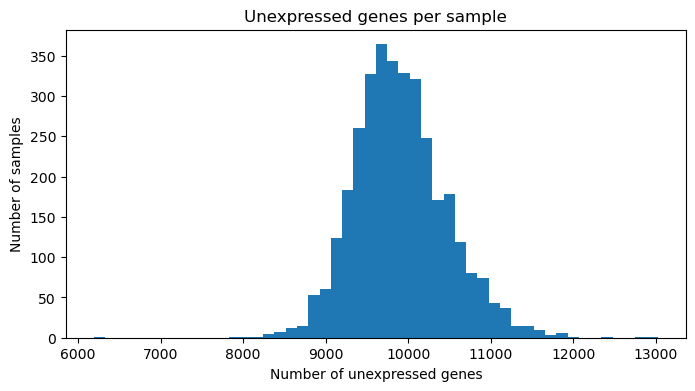

Samples with unusually high numbers of unexpressed genes: 35


In [41]:
num_unexpressed = (np.abs(em_T - pseudo_zero) < tolerance).sum(axis=1)
plt.figure(figsize=(8,4))
plt.hist(num_unexpressed, bins=50)
plt.xlabel("Number of unexpressed genes")
plt.ylabel("Number of samples")
plt.title("Unexpressed genes per sample")
plt.show()

# Flag samples with unusually high numbers of unexpressed genes (e.g., >99th percentile)
unexpr_threshold = num_unexpressed.quantile(0.99)
bad_samples_unexpr = num_unexpressed[num_unexpressed > unexpr_threshold].index
print(f"Samples with unusually high numbers of unexpressed genes: {len(bad_samples_unexpr)}")


In [44]:
clinical_df['many_unexpressed_genes'] = False
clinical_df.loc[bad_samples_unexpr, 'many_unexpressed_genes'] = True

overlap = clinical_df[(clinical_df['expression_outlier'] != 'none') & (clinical_df['many_unexpressed_genes'])]
print(f"Samples flagged by both metrics: {len(overlap)}")


Samples flagged by both metrics: 7


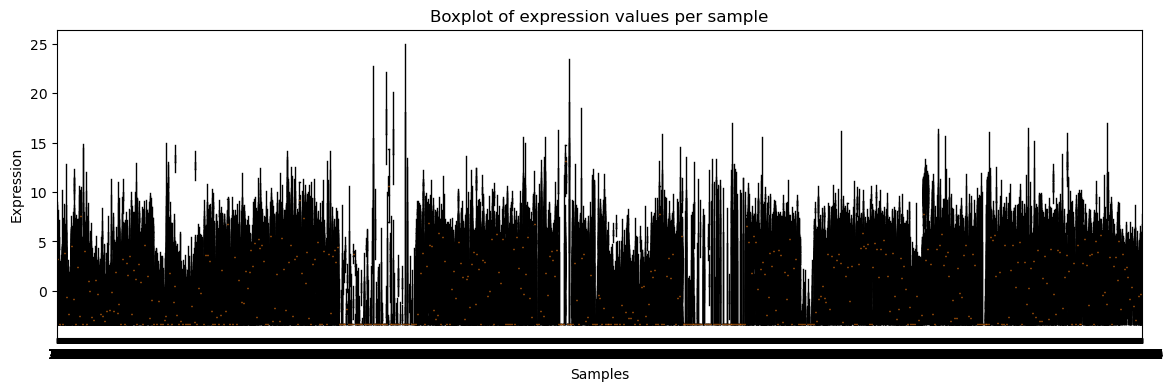

In [45]:
plt.figure(figsize=(14, 4))
plt.boxplot(em_T.values, showfliers=False)
plt.xlabel("Samples")
plt.ylabel("Expression")
plt.title("Boxplot of expression values per sample")
plt.show()


## Analysis of Technical Replicates
The dataset contains technical replicates, indicated by "repl" behind the id number -> I would like to check whether they are similar to the original sample.

In [47]:
sample_ids = em_T.index.tolist()

# Map technical replicates to their primary sample
def get_primary_id(sample_id):
    return sample_id.replace("repl", "") if sample_id.endswith("repl") else sample_id

# Build a DataFrame mapping
replicate_map = pd.DataFrame({
    "sample_id": sample_ids,
    "primary_id": [get_primary_id(sid) for sid in sample_ids]
})


In [52]:
from scipy.stats import pearsonr

bad_replicate_groups = []

for pid, group in replicate_map.groupby("primary_id"):
    sample_group = group["sample_id"].tolist()
    if len(sample_group) > 1:
        # Get the expression for these samples (rows in em_T)
        expr = em_T.loc[sample_group]
        # Calculate pairwise correlations
        corrs = expr.T.corr()
        upper = corrs.values[np.triu_indices_from(corrs.values, k=1)]
        mean_corr = np.mean(upper)
        print(f"Primary {pid}: {len(sample_group)} samples, mean pairwise corr = {mean_corr:.3f}")
        # Flag very low correlation groups
        if mean_corr < 0.90:
            bad_replicate_groups.append(pid)


Primary F1101: 2 samples, mean pairwise corr = 0.971
Primary F1108: 2 samples, mean pairwise corr = 0.972
Primary F112: 2 samples, mean pairwise corr = 0.961
Primary F1143: 2 samples, mean pairwise corr = 0.973
Primary F1156: 2 samples, mean pairwise corr = 0.972
Primary F116: 2 samples, mean pairwise corr = 0.964
Primary F1167: 2 samples, mean pairwise corr = 0.966
Primary F1197: 2 samples, mean pairwise corr = 0.973
Primary F1214: 2 samples, mean pairwise corr = 0.968
Primary F1283: 2 samples, mean pairwise corr = 0.975
Primary F1392: 2 samples, mean pairwise corr = 0.960
Primary F1438: 2 samples, mean pairwise corr = 0.976
Primary F1439: 2 samples, mean pairwise corr = 0.963
Primary F1497: 2 samples, mean pairwise corr = 0.965
Primary F1515: 2 samples, mean pairwise corr = 0.962
Primary F1519: 2 samples, mean pairwise corr = 0.974
Primary F1580: 2 samples, mean pairwise corr = 0.973
Primary F1581: 2 samples, mean pairwise corr = 0.976
Primary F1582: 2 samples, mean pairwise corr = 0

In [53]:
print(f"Bad replicate groups (mean corr < 0.9): {len(bad_replicate_groups)}")

Bad replicate groups (mean corr < 0.9): 0


We can see that most technical replicates agree well with the values from the original measurements.

I take 0.9 as a conservative "something went wrong" cutoff, but would like to take 0.95 to continue from here.

Strategy:
- good agreement (>0.95 pearson): average the original and the technical replicate
- bad agreement: (<0.95 pearson): only keep original (this applies only to two samples)

In [54]:
em_T_collapsed = em_T.copy()
rows_to_drop = []

for pid, group in replicate_map.groupby("primary_id"):
    sample_group = group["sample_id"].tolist()
    # Only consider groups with more than one sample (i.e., with technical replicates)
    if len(sample_group) > 1:
        expr = em_T.loc[sample_group]
        corrs = expr.T.corr()
        upper = corrs.values[np.triu_indices_from(corrs.values, k=1)]
        mean_corr = np.mean(upper)
        if pid in bad_replicate_groups:
            print(f"Bad replicate group: {pid}")
            # Keep only the primary sample (drop all other replicates)
            for sid in sample_group:
                if sid != pid:
                    rows_to_drop.append(sid)
        else:
            # Good group: average all replicates, assign to primary sample row
            avg = expr.mean(axis=0)
            em_T_collapsed.loc[pid] = avg
            # Drop all replicates except the primary
            for sid in sample_group:
                if sid != pid:
                    rows_to_drop.append(sid)

# Actually drop rows
em_T_collapsed = em_T_collapsed.drop(rows_to_drop, axis=0)

# Sanity check
print(f"Original: {em_T.shape}, After collapsing: {em_T_collapsed.shape}")


Original: (3409, 30865), After collapsing: (3273, 30865)


Correct, now we have removed the 136 technical replicates.

# BLABLA

Applying median-centering per column.

In [55]:
median_centered = filtered_em_T.sub(filtered_em_T.median(axis=0), axis=1)

# After calculating median_centered
median_centered = filtered_em_T.sub(filtered_em_T.median(axis=0), axis=1)

# Check for infinite values and replace them with NaN before saving
inf_count_median = np.isinf(median_centered.values).sum()
if inf_count_median > 0:
    print(f"ATTENTION: {inf_count_median} infinite values found in median_centered DataFrame. Replacing with NaN.")
    median_centered.replace([np.inf, -np.inf], np.nan, inplace=True)

Applying z-scoring per column.

In [56]:
# Drop columns with zero std dev after median-centering
stds = median_centered.std(axis=0, ddof=0)
zero_std_cols = stds[stds == 0].index

print(f"Dropping {len(zero_std_cols)} columns with zero standard deviation after centering.")

median_centered = median_centered.drop(columns=zero_std_cols)


Dropping 2 columns with zero standard deviation after centering.


In [57]:
# Shows columns with any NaNs and how many there are
na_cols = median_centered.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


In [58]:
print(np.isinf(median_centered.values).sum())  # total count
print((~np.isfinite(median_centered)).sum())   # includes inf, -inf, NaN

0
5_8S_rRNA    0
5S_rRNA      0
7SK          0
A1BG         0
A1BG-AS1     0
            ..
ZYG11A       0
ZYG11B       0
ZYX          0
ZZEF1        0
ZZZ3         0
Length: 26148, dtype: int64


In [59]:
median_centered.replace([np.inf, -np.inf], np.nan, inplace=True)
print("After replacing inf/-inf, NaNs per column:")
print(median_centered.isna().sum()[lambda x: x > 0])


After replacing inf/-inf, NaNs per column:
Series([], dtype: int64)


In [61]:
median_centered.shape

(3409, 26148)

In [ ]:
median_centered.to_csv(os.getenv("MEDIAN_CENTERED"), float_format='%.20f')

In [ ]:
zscored = median_centered.sub(median_centered.mean(axis=0), axis=1)
zscored = zscored.div(median_centered.std(axis=0, ddof=0), axis=1)

inf_count_zscored = np.isinf(zscored.values).sum()
if inf_count_zscored > 0:
    print(f"ATTENTION: {inf_count_zscored} infinite values found in zscored DataFrame. Replacing with NaN.")
    zscored.replace([np.inf, -np.inf], np.nan, inplace=True)


In [40]:
# Shows columns with any NaNs and how many there are
na_cols = zscored.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


In [ ]:
zscored.to_csv(os.getenv("ZSCORED"), float_format='%.20f')